In [25]:
# import required libraries for dataframe and visualization

import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import datetime as dt

# import required libraries for clustering
import sklearn  
from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import KMeans    
from sklearn.metrics import silhouette_score  #Silhouette Score
from scipy.cluster.hierarchy import linkage   #Linkage Metrics
from scipy.cluster.hierarchy import dendrogram  #Dendogram
from scipy.cluster.hierarchy import cut_tree    #Cut_Tree

In [26]:
retail = pd.read_csv('OnlineRetail.csv', encoding = "ISO-8859-1")

# Information of type and values count
print(retail.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None


In [27]:
# Percentage of null values in each column
df_null = round(100*(retail.isnull().sum())/len(retail), 2)
print(df_null , "Pre null values")

retail = retail.dropna()

# Percentage of null values in each column
df_null = round(100*(retail.isnull().sum())/len(retail), 2)

# cast integer to string
retail['CustomerID'] = retail['CustomerID'].astype(str)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64 Pre null values


In [28]:
# Sales calculation
retail['Amount'] = retail['Quantity']*retail['UnitPrice']

# Spend by each customer
SaleByEachCustomer = retail.groupby('CustomerID')['Amount'].sum()

#Resetting Index
SaleByEachCustomer = SaleByEachCustomer.reset_index()
SaleByEachCustomer.head()


,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [29]:
# Grouping Customer's ID and counting total number of invoices
FequencyOfEachCustomer = retail.groupby('CustomerID')['InvoiceNo'].count()

#Resetting Index
FequencyOfEachCustomer = FequencyOfEachCustomer.reset_index()

#Renaming Columns of df: FequencyOfEachCustomer 
FequencyOfEachCustomer.columns = ['CustomerID', 'Frequency']
FequencyOfEachCustomer.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [36]:
# Merging SaleByEachCustomer and FequencyOfEachCustomer 
CustomerProfile = pd.merge(SaleByEachCustomer , FequencyOfEachCustomer, on='CustomerID', how='inner')
CustomerProfile.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [37]:
# Recency
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')

max_date = max(retail['InvoiceDate'])
print(max_date)

retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

2011-12-09 12:50:00


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [38]:
# Compute last transaction date to get the recency of customers

LastVisit = retail.groupby('CustomerID')['Diff'].min()
LastVisit = LastVisit.reset_index()
LastVisit['Diff'] = LastVisit['Diff'].dt.days
LastVisit.head(2)

,CustomerID,Diff
0,12346.0,325
1,12347.0,1


In [39]:
CustomerProfile = pd.merge(CustomerProfile, LastVisit, on='CustomerID', how='inner')
CustomerProfile.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
CustomerProfile.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


Text(0.5, 0, 'Attributes')

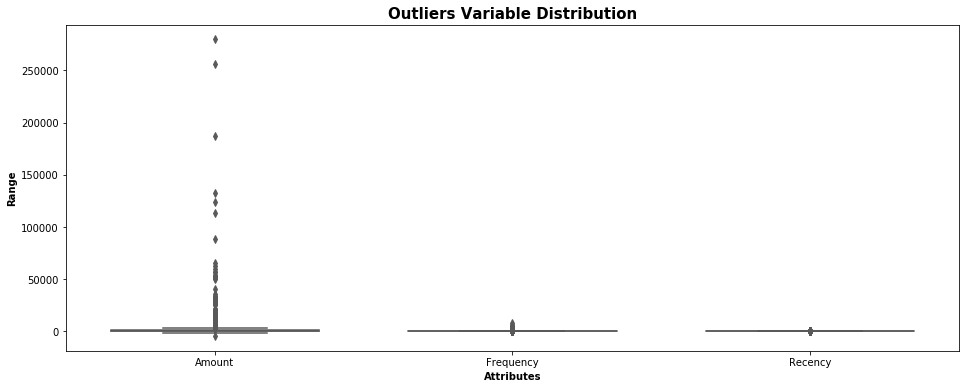

In [40]:
# Outlier Analysis of Amount Frequency and Recency

attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [16,6] #width, height in inches. 72 ppi

sns.boxplot(data = CustomerProfile[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=4, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 15, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [41]:
# Removing (statistical) outliers for Amount
Q1 = CustomerProfile.Amount.quantile(0.05)
Q3 = CustomerProfile.Amount.quantile(0.95)
IQR = Q3 - Q1

CustomerProfile = CustomerProfile[(CustomerProfile.Amount >= Q1 - 1.5*IQR) & (CustomerProfile.Amount <= Q3 + 1.5*IQR)]
# print(Q1.min , )
      
# Removing (statistical) outliers for Recency
Q1 = CustomerProfile.Recency.quantile(0.05)
Q3 = CustomerProfile.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = CustomerProfile[(CustomerProfile.Recency >= Q1 - 1.5*IQR) & (CustomerProfile.Recency <= Q3 + 1.5*IQR)]
# print(rfm['Recency'].min() , rfm['Recency'].max(), "Recency")

# Removing (statistical) outliers for Frequency
Q1 = CustomerProfile.Frequency.quantile(0.05)
Q3 = CustomerProfile.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = CustomerProfile[(CustomerProfile.Frequency >= Q1 - 1.5*IQR) & (CustomerProfile.Frequency <= Q3 + 1.5*IQR)]
# print(rfm['Frequency'].min() , rfm['Frequency'].max(), "Frequency")

In [42]:

CustomerProfile_df = CustomerProfile[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
CustomerProfile_df_scaled = scaler.fit_transform(CustomerProfile_df)
CustomerProfile_df_scaled.shape

(4313, 3)

In [43]:
CustomerProfile_df_scaled = pd.DataFrame(CustomerProfile_df_scaled)
CustomerProfile_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
CustomerProfile_df_scaled.head()

,Amount,Frequency,Recency
0,-0.721944,-0.637326,2.307057
1,1.682279,0.791337,-0.903167
2,0.280601,-0.407152,-0.179876
3,0.258461,-0.073798,-0.734729
4,-0.535407,-0.518271,2.148527


In [58]:
# Building a KMeans model
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(CustomerProfile_df_scaled)

kmeans.labels_

array([1, 3, 0, ..., 0, 2, 0], dtype=int32)

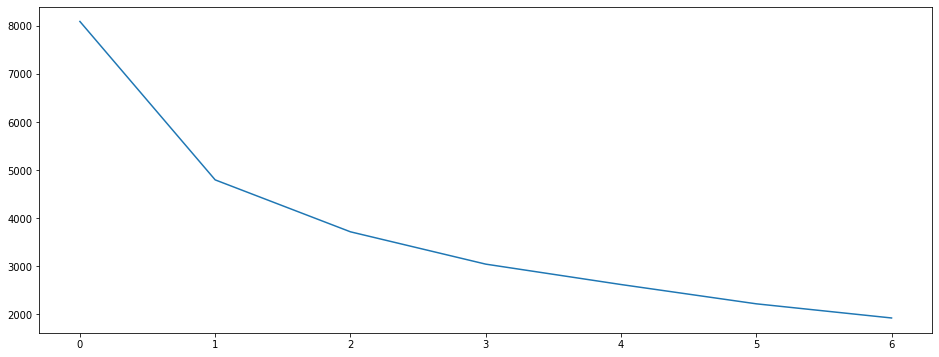

In [59]:
# Elbow-curve/SSD for finding the optimal number of clusters

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7,8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(CustomerProfile_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

In [60]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(CustomerProfile_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(CustomerProfile_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5540544157709008
For n_clusters=3, the silhouette score is 0.521209985231851
For n_clusters=4, the silhouette score is 0.5012987145577453
For n_clusters=5, the silhouette score is 0.4951866202787596
For n_clusters=6, the silhouette score is 0.4327254970624728
For n_clusters=7, the silhouette score is 0.42839064311892144
For n_clusters=8, the silhouette score is 0.42598867170171906


In [64]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(CustomerProfile_df_scaled)

kmeans.labels_

CustomerProfile['Cluster_Id'] = kmeans.labels_
CustomerProfile.head(5)

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,12346.0,0.00,2,325,0
1,12347.0,4310.00,182,1,2
2,12348.0,1797.24,31,74,1
3,12349.0,1757.55,73,18,1
4,12350.0,334.40,17,309,0


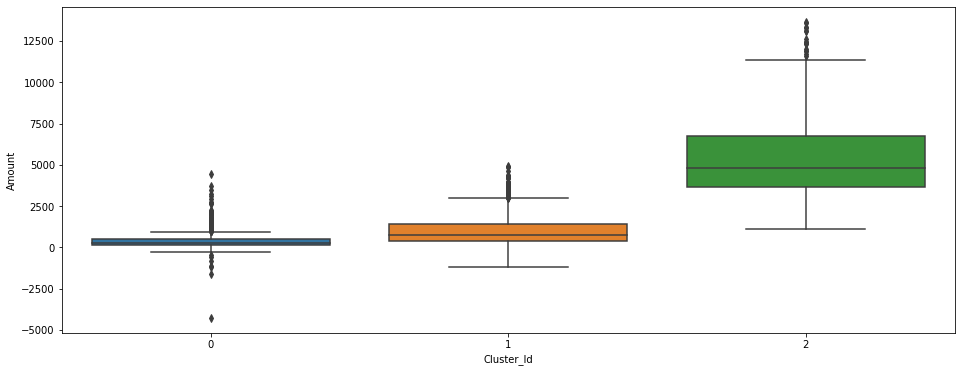

In [65]:
sns.boxplot(x='Cluster_Id', y='Amount', data=CustomerProfile)

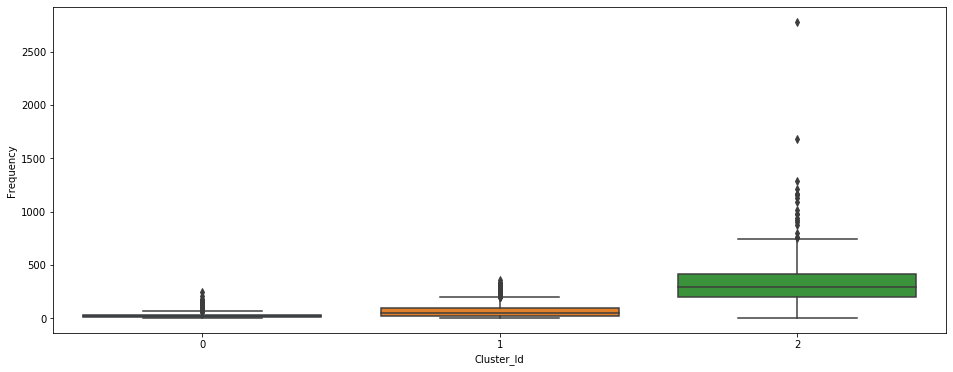

In [66]:
sns.boxplot(x='Cluster_Id', y='Frequency', data=CustomerProfile)

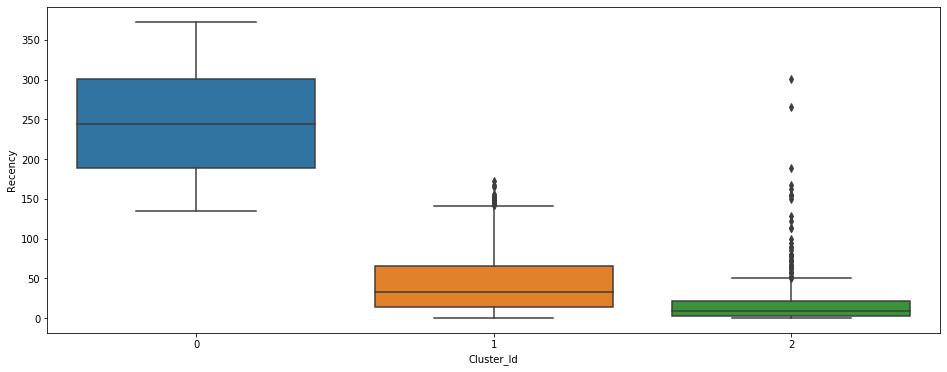

In [67]:
sns.boxplot(x='Cluster_Id', y='Recency', data=CustomerProfile)

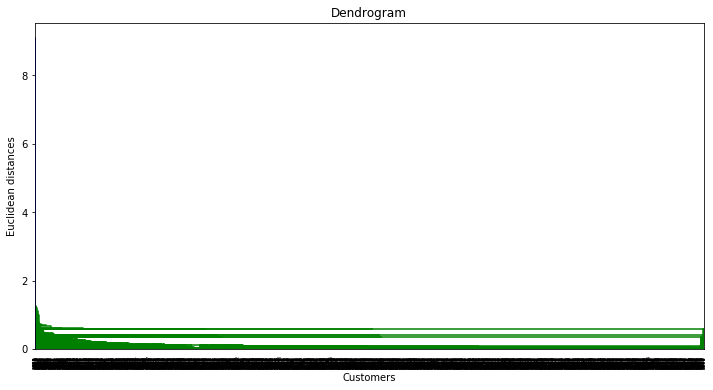

In [82]:
# Hirerachical Clustering

# Single linkage: 

plt.rcParams['figure.figsize'] = [6,3] #width, height in inches. 100 dpi

mergings = linkage(CustomerProfile_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

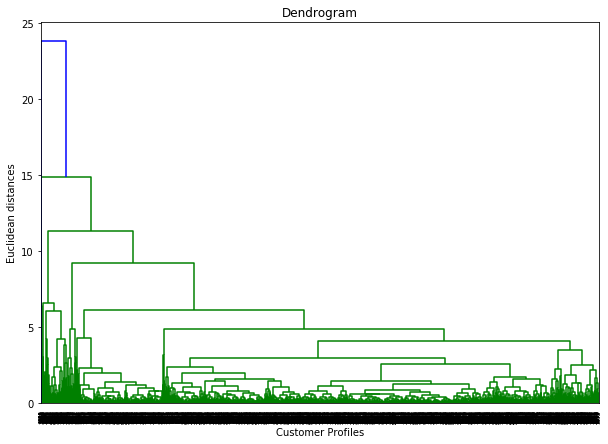

In [85]:
# Complete linkage: 
mergings = linkage(CustomerProfile_df_scaled, method="complete", metric='euclidean')
plt.rcParams['figure.figsize'] = [10,7] #width, height in inches

dendrogram(mergings)
# plt.figure(figsize=(10, 7))  
plt.title('Dendrogram')
plt.xlabel('Customer Profiles')
plt.ylabel('Euclidean distances')
plt.show()

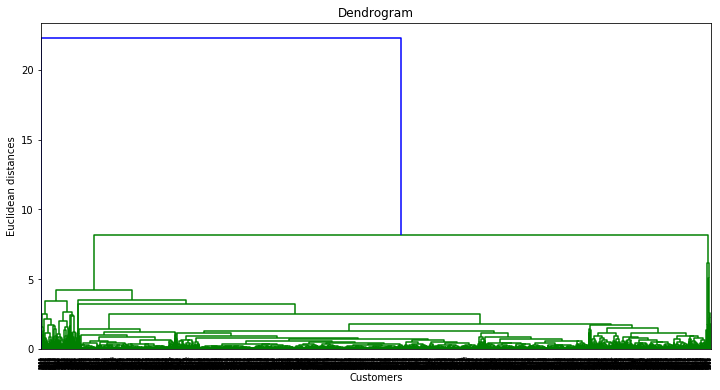

In [81]:
# Average linkage: 

mergings = linkage(CustomerProfile_df_scaled, method="average", metric='euclidean')
dendrogram(mergings)
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

In [93]:
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels


array([0, 0, 0, ..., 0, 0, 0])

In [94]:
# Assign cluster labels

CustomerProfile['Cluster_Labels'] = cluster_labels
CustomerProfile.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id,Cluster_Labels
0,12346.0,0.00,2,325,0,0
1,12347.0,4310.00,182,1,2,0
2,12348.0,1797.24,31,74,1,0
3,12349.0,1757.55,73,18,1,0
4,12350.0,334.40,17,309,0,0


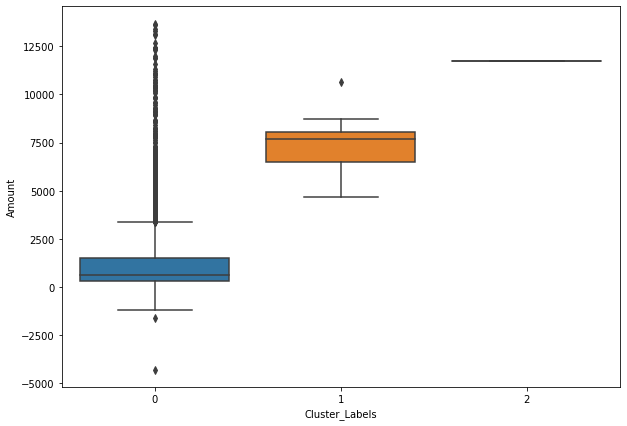

In [95]:
sns.boxplot(x='Cluster_Labels', y='Amount', data=CustomerProfile)


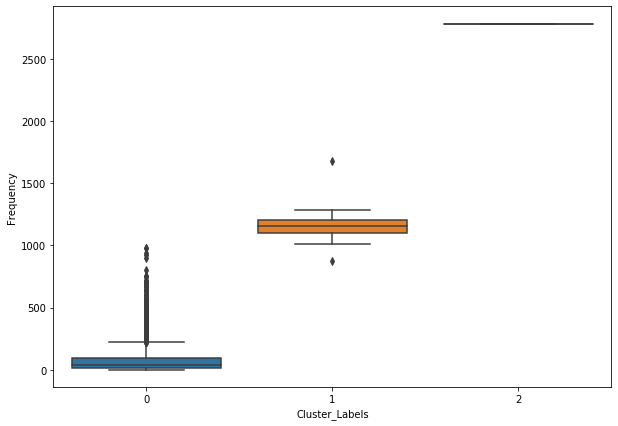

In [96]:
sns.boxplot(x='Cluster_Labels', y='Frequency', data=CustomerProfile)


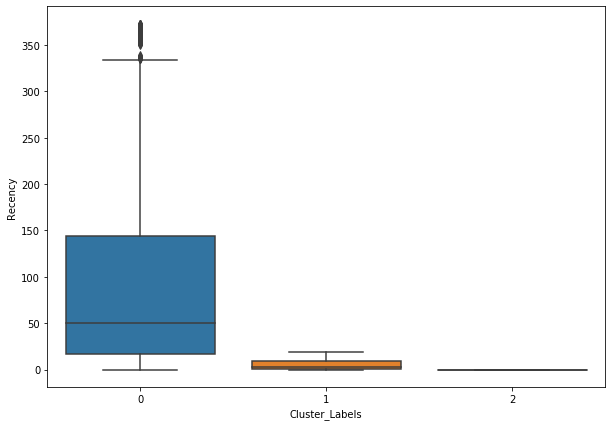

In [97]:
sns.boxplot(x='Cluster_Labels', y='Recency', data=CustomerProfile)
